In [1]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from collections import deque

# Configuration
DATA_DIR = "generated_datasets"
RESULTS_DIR = "results_streaming"
os.makedirs(RESULTS_DIR, exist_ok=True)

WINDOW_SIZE = 1000  # max buffer size
BATCH_SIZE = 300
CONTAMINATION = 0.05


In [2]:
def zscore_normalize(ts):
    return (ts - np.mean(ts)) / (np.std(ts) + 1e-8)

def moving_average(ts, window=3):
    return np.convolve(ts, np.ones(window) / window, mode='same')

def preprocess_series(ts):
    ts = zscore_normalize(ts)
    ts = moving_average(ts, window=3)
    return ts


In [3]:
def run_isoforest_streaming_v2(ts):
    buffer = deque(maxlen=WINDOW_SIZE)
    preds, scores = [], []

    for start in range(0, len(ts) - BATCH_SIZE, BATCH_SIZE):
        batch = ts[start:start + BATCH_SIZE]
        buffer.extend(batch)

        if len(buffer) < BATCH_SIZE:
            # Skip early rounds until we fill the buffer
            preds.extend([0] * BATCH_SIZE)
            scores.extend([0.0] * BATCH_SIZE)
            continue

        model = IsolationForest(contamination=CONTAMINATION, random_state=42)
        model.fit(np.array(buffer).reshape(-1, 1))
        batch_scores = -model.decision_function(batch.reshape(-1, 1))
        threshold = np.percentile(batch_scores, 100 * (1 - CONTAMINATION))
        batch_preds = (batch_scores > threshold).astype(int)

        preds.extend(batch_preds)
        scores.extend(batch_scores)

    return np.array(preds), np.array(scores)



Processing normality_1_daphnet.npy
Precision: 0.046, Recall: 0.042, F1: 0.044, AUC: 0.482


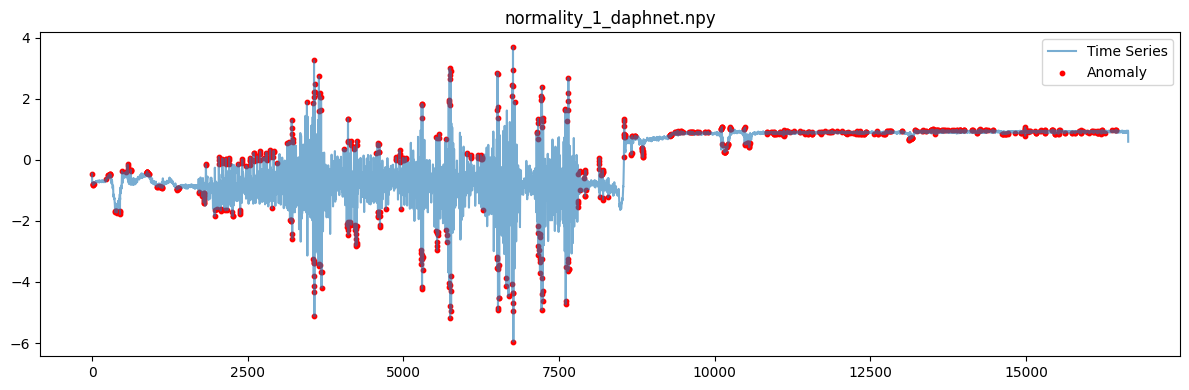


Processing normality_1_genesis.npy
Precision: 0.052, Recall: 0.011, F1: 0.018, AUC: 0.208


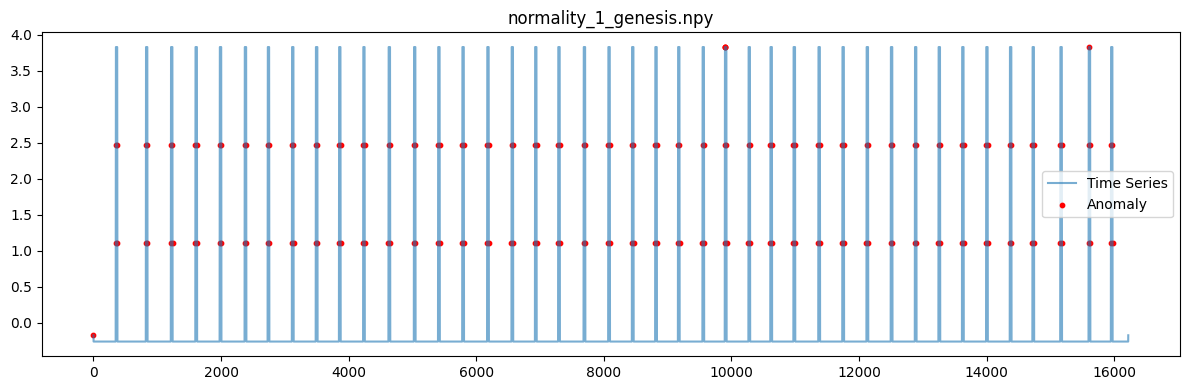


Processing normality_1_nasa-msl.npy
Precision: 0.050, Recall: 0.050, F1: 0.050, AUC: 0.730


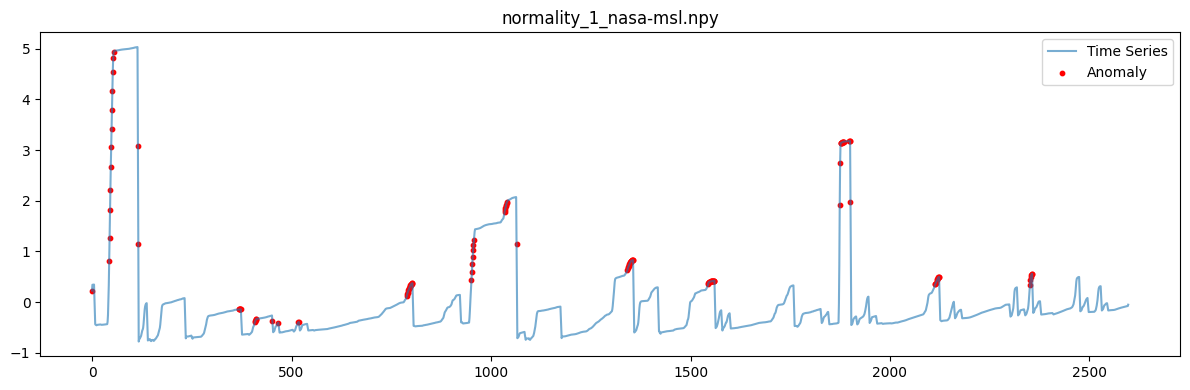


Processing normality_2_1_daphnet_genesis.npy
Precision: 0.048, Recall: 0.048, F1: 0.048, AUC: 0.402


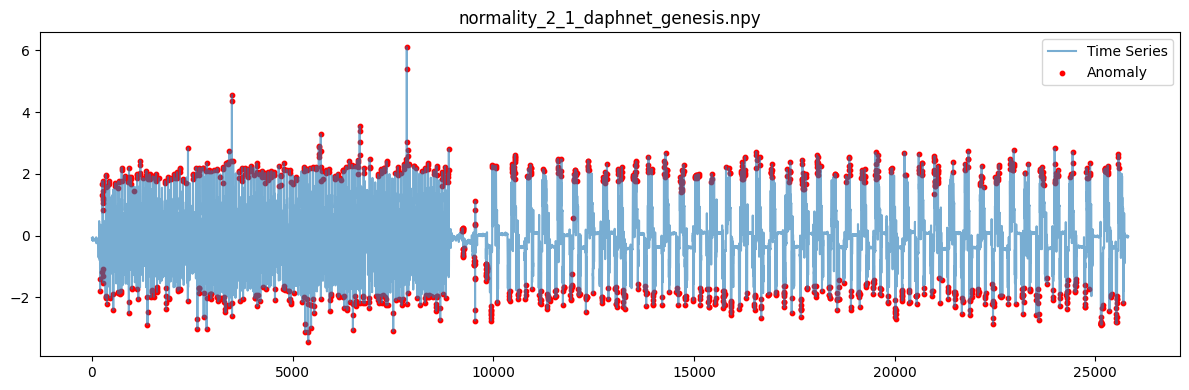


Processing normality_2_2_daphnet_nasa-msl.npy
Precision: 0.060, Recall: 0.058, F1: 0.059, AUC: 0.606


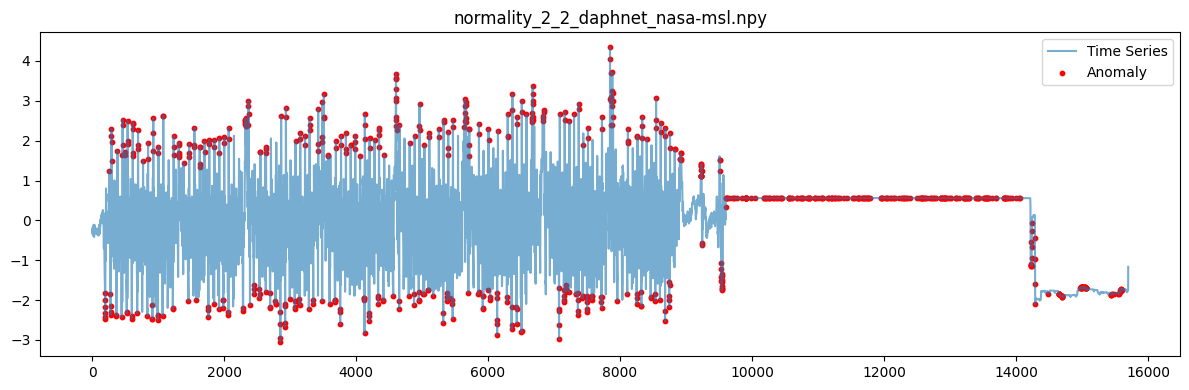


Processing normality_2_3_genesis_nasa-msl.npy
Precision: 0.040, Recall: 0.040, F1: 0.040, AUC: 0.504


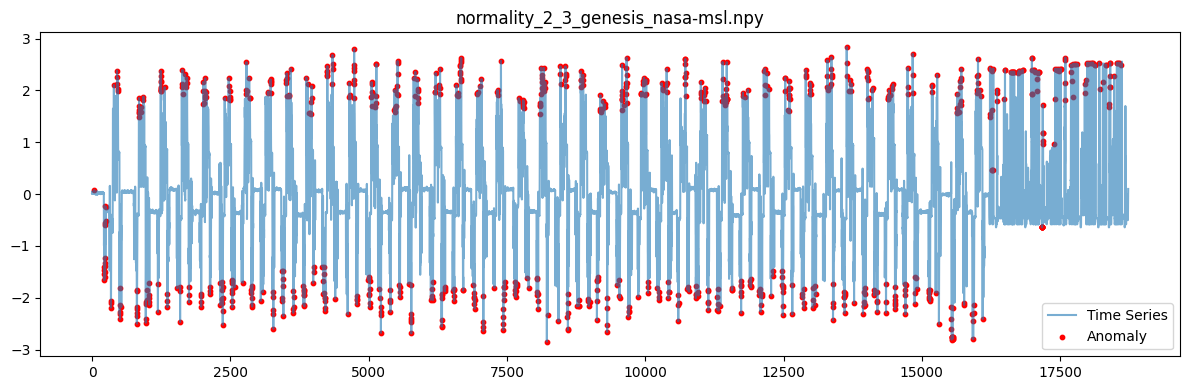


Processing normality_3_1_daphnet_genesis_nasa-msl.npy
Precision: 0.051, Recall: 0.049, F1: 0.050, AUC: 0.702


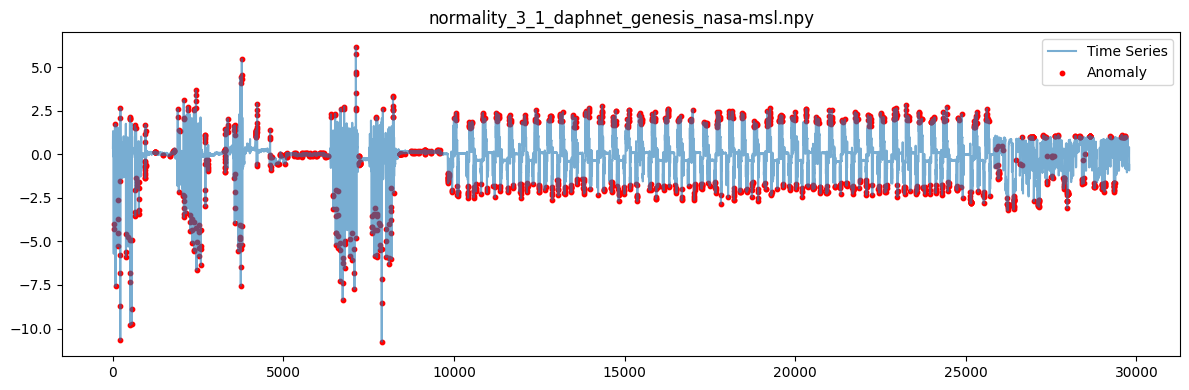


Processing normality_3_2_genesis_nasa-msl_daphnet.npy
Precision: 0.054, Recall: 0.042, F1: 0.048, AUC: 0.468


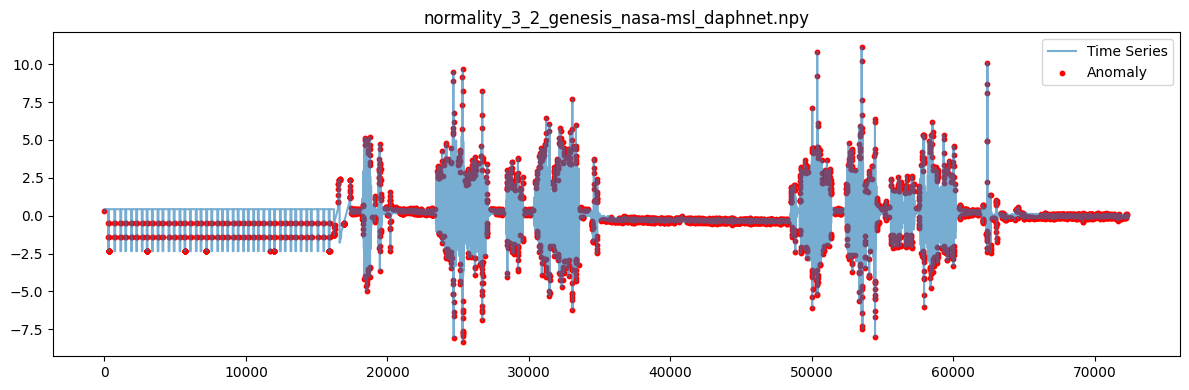


Processing normality_3_3_nasa-msl_daphnet_genesis.npy
Precision: 0.016, Recall: 0.010, F1: 0.013, AUC: 0.796


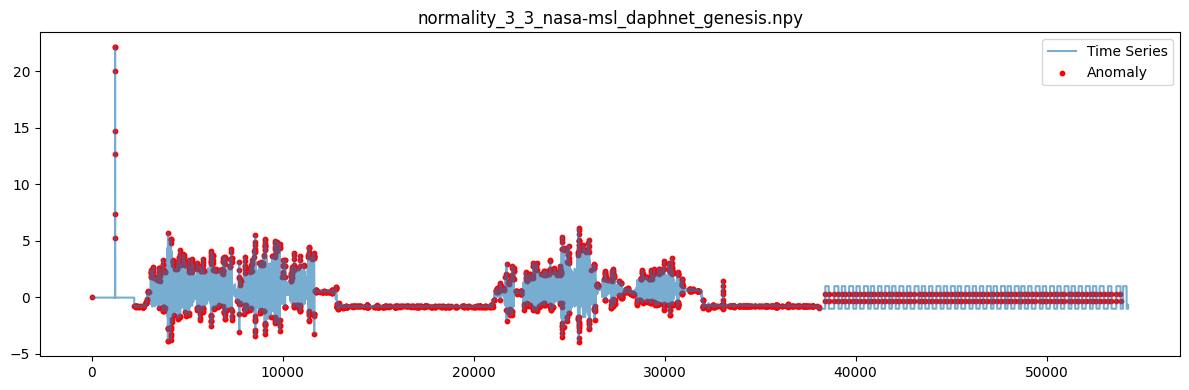

In [4]:
summary = []

for fname in sorted(os.listdir(DATA_DIR)):
    if not fname.endswith(".npy") or "_boundaries" in fname:
        continue

    print(f"\nProcessing {fname}")
    raw_ts = np.load(os.path.join(DATA_DIR, fname))

    if len(raw_ts) < BATCH_SIZE * 2:
        print("Skipped: Too short for streaming processing")
        continue

    ts = preprocess_series(raw_ts)  # Apply preprocessing

    preds, scores = run_isoforest_streaming_v2(ts)

    if len(preds) == 0:
        print("Skipped: No predictions made")
        continue

    # Create synthetic ground truth (last X% as anomalies)
    labels = np.zeros(len(scores))
    labels[-int(len(scores) * CONTAMINATION):] = 1

    # Evaluation
    p = precision_score(labels, preds, zero_division=0)
    r = recall_score(labels, preds, zero_division=0)
    f = f1_score(labels, preds, zero_division=0)
    a = roc_auc_score(labels, scores) if len(set(labels)) > 1 else 0.0

    print(f"Precision: {p:.3f}, Recall: {r:.3f}, F1: {f:.3f}, AUC: {a:.3f}")

    # Visualization
    plt.figure(figsize=(12, 4))
    plt.plot(ts, label="Time Series", alpha=0.6)
    anomaly_idx = np.where(preds == 1)[0]
    plt.scatter(anomaly_idx, ts[anomaly_idx], color='red', s=10, label="Anomaly")
    plt.title(fname)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Save results
    summary.append(dict(dataset=fname,
                        length=len(ts),
                        precision=round(p, 3),
                        recall=round(r, 3),
                        f1=round(f, 3),
                        auc=round(a, 3)))

In [5]:
if summary:
    df = pd.DataFrame(summary).set_index("dataset")
    display(df)
    df.to_csv(os.path.join(RESULTS_DIR, "isoforest_streaming_variant2.csv"))
else:
    print("No datasets were successfully processed.")


,length,precision,recall,f1,auc
dataset,,,,,
normality_1_daphnet.npy,16640,0.046,0.042,0.044,0.482
normality_1_genesis.npy,16220,0.052,0.011,0.018,0.208
normality_1_nasa-msl.npy,2598,0.050,0.050,0.050,0.730
normality_2_1_daphnet_genesis.npy,25820,0.048,0.048,0.048,0.402
normality_2_2_daphnet_nasa-msl.npy,15700,0.060,0.058,0.059,0.606
normality_2_3_genesis_nasa-msl.npy,18731,0.040,0.040,0.040,0.504
normality_3_1_daphnet_genesis_nasa-msl.npy,29789,0.051,0.049,0.050,0.702
normality_3_2_genesis_nasa-msl_daphnet.npy,72405,0.054,0.042,0.048,0.468
normality_3_3_nasa-msl_daphnet_genesis.npy,54278,0.016,0.010,0.013,0.796
